In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

import plotly.graph_objects as go
import pandas as pd

from quimb import *
import time


In [2]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


In [3]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


# Spectrum of reduced density matrix:

In [59]:
Nrep=100
r=2 # local Hilbert space dim
symm=1

La=4
Lb=4
Na=r**La
Nb=r**Lb

Lc=8

Npt_sw = np.arange(1,int((La+Lb+Lc)/2)+1)

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

# print(len(i_ab))
# print(s_ab[np.ix_(i_ab),:])

# for i_r in range(La+Lb+1):
#     print(i_ab[i_r])
#     print(s_ab[np.ix_(i_ab[i_r]),:])

# for i_r in range(Lc+1):
#     print(i_c[i_r])
#     print(s_c[np.ix_(i_c[i_r]),:])

v1=np.zeros(Nrep*Nb*Na)

t_timer= time.time()
for i_N in range(len(Npt_sw)):
    Npt=Npt_sw[i_N]
    print(Npt)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    
    for i_r in range(Nrep):
        i_r
        if symm==1:
            for i_pt in range(min(Npt,La+Lb)+1):
                if (Npt-i_pt) <= Lc:
#                     print(i_ab[i_pt],i_c[Npt-i_pt])
                    X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)
        l1=np.linalg.eigvalsh(rho)
        v1[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r*l1

    out_dir = 'data/' 
    if symm==1:
        f1= 'ES_U1_%d_LAB_%d_%d_symm.npz' % (Npt,La+Lb,Lc)
    else:
        f1= 'ES_U1_%d_LAB_%d_%d.npz' % (Npt,La+Lb,Lc)

    fname = out_dir+f1
    np.savez(fname, evals=v1, Nrep=Nrep)

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")




1
2
3
4
5
6
7
8
Finished, elapsed time = 9.58 sec


ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!


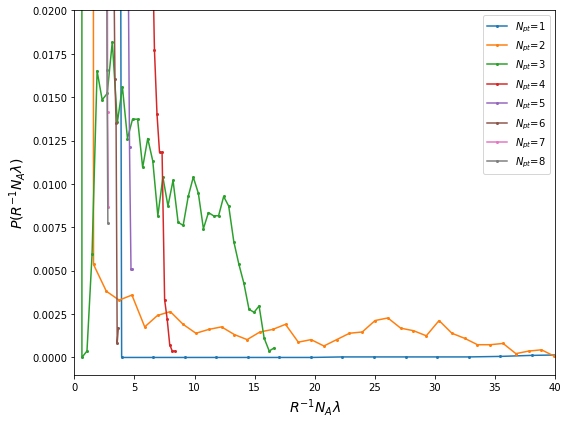

In [64]:
# post processing data

out_dir = 'data/' 
symm=1

    
def MP_dist(N,Q,x):
    # my Q is from Ludwig's paper
    lp=(1+sqrt(Q))**2/N
    ln=(1-sqrt(Q))**2/N
    fx= 1/(2*pi*Q)/x *((lp-x)*(x-ln)+0j)**0.5
    return fx

num_bins = 40

# plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(8,6))


for i_N in range(len(Npt_sw)):
    Npt=Npt_sw[i_N]
    
    if symm==1:
        f1= 'ES_U1_%d_LAB_%d_%d_symm.npz' % (Npt,La+Lb,Lc)
    else:
        f1= 'ES_U1_%d_LAB_%d_%d.npz' % (Npt,La+Lb,Lc)

    fname = out_dir+f1

    npzfile = np.load(fname)
    v1=npzfile['evals']
    print('ES was loaded!')

    
    n, bin_edges = np.histogram(v1, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    if symm==1:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])*r    
    else:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])  
        
    plt.plot(bins_center,n,'o-',markersize=2,color='C%d' % (i_N), label='$N_{pt}$=%d' % (Npt))
    
#     xplot=np.linspace(0.5*np.min(bins_center),1.2*np.max(bins_center),400)
#     xplot=np.linspace(0.01,4,1000)
#     fx= MP_dist(Nab_r,Na*Nb/r**Lc,xplot/Nab_r)
# #     plt.plot(xplot,np.real(fx),color='C%d' % (i_l))
#     plt.plot(xplot,np.real(fx),color='C%d' % (i_N))

fsize=14
plt.ylim(-0.001,0.02)
plt.xlim(0,40)
# plt.yticks(np.arange(0.,2.1,0.5))
plt.legend()
if symm==1:
    plt.ylabel(r'$P(R^{-1} N_A\lambda)$',fontsize = fsize)
    plt.xlabel(r"$R^{-1} N_A \lambda$",fontsize = fsize)
else:
    plt.ylabel(r'$P(N_A \lambda)$',fontsize = fsize)
    plt.xlabel(r"$N_A \lambda$",fontsize = fsize)
plt.tight_layout()

# if symm==1:
#     plt.savefig('figs/ES_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/ES_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

# Negativity spectrum:

In [338]:
Nrep=100
r=2 # local Hilbert space dim
symm=1

La=6
Lb=6
Na=r**La
Nb=r**Lb

Lc=8

# Npt_sw = [int((La+Lb+Lc)/2)] #np.arange(1,int((La+Lb+Lc)/2)+1)
Npt_sw = np.arange(4,int((La+Lb+Lc)/2)+1)

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

# print(len(i_ab))
# print(s_ab[np.ix_(i_ab),:])

# for i_r in range(La+Lb+1):
#     print(i_ab[i_r])
#     print(s_ab[np.ix_(i_ab[i_r]),:])

# for i_r in range(Lc+1):
#     print(i_c[i_r])
#     print(s_c[np.ix_(i_c[i_r]),:])

v1T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()
for i_N in range(len(Npt_sw)):
    Npt=Npt_sw[i_N]
    print(Npt)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    
    for i_r in range(Nrep):
        i_r
        if symm==1:
            for i_pt in range(min(Npt,La+Lb)+1):
                if (Npt-i_pt) <= Lc:
#                     print(i_ab[i_pt],i_c[Npt-i_pt])
                    X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT2 = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT2)
        v1T[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T

    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_U1_%d_Labc_%d_%d_%d_symm.npz' % (Npt,La,Lb,Lc)
    else:
        f1= 'NS_U1_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
    print(f1+' was saved!')
    fname = out_dir+f1
    np.savez(fname, evals=v1T, Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


4
NS_U1_4_Labc_6_6_8_symm.npz was saved!
5
NS_U1_5_Labc_6_6_8_symm.npz was saved!
6
NS_U1_6_Labc_6_6_8_symm.npz was saved!
7
NS_U1_7_Labc_6_6_8_symm.npz was saved!
8
NS_U1_8_Labc_6_6_8_symm.npz was saved!
9
NS_U1_9_Labc_6_6_8_symm.npz was saved!
10
NS_U1_10_Labc_6_6_8_symm.npz was saved!
Finished, elapsed time = 2156.18 sec


ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!


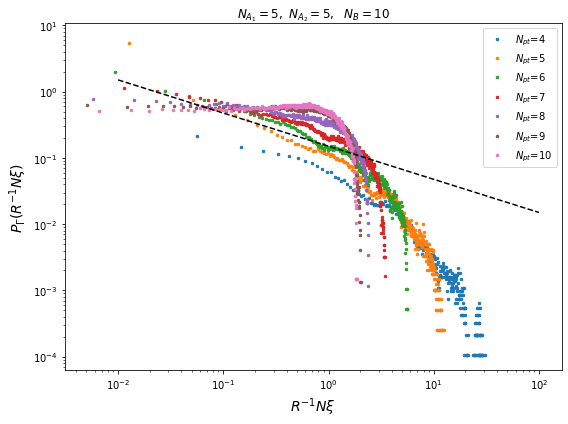

In [396]:
out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1


Labc=20
La=5
Lb=5
Lab = La+Lb
Na=r**La
Nb=r**Lb

Lc=Labc-Lab

# Npt_sw = [int((La+Lb+Lc)/2)] #np.arange(1,int((La+Lb+Lc)/2)+1)
Npt_sw = np.arange(4,11)#int((La+Lb+Lc)/2)+1)
# Npt_sw = [4]

def semicirc_dist(N,Q,x,x0):
    # my Q is from Ludwig's paper
    R= 2*sqrt(Q)
    fx= 2/(pi*R**2)*(R**2-(x-x0)**2+0j)**0.5
    return fx


# plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(8,6))

for i_N in range(len(Npt_sw)):
    Npt=Npt_sw[i_N]
    
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_U1_%d_Labc_%d_%d_%d_symm.npz' % (Npt,La,Lb,Lc)
    else:
        f1= 'NS_U1_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    v1T=npzfile['evals']
    print('ES was loaded!')
    
    if r**Lc > 4* r**(La+Lb)+1:
        num_bins = 400
#         print(L)
    else:
        num_bins = 400

    n, bin_edges = np.histogram(v1T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2

    if symm==1:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])    
    else:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])  
        
    plt.plot(bins_center,n,'.',markersize=5,color='C%d' % (i_N), label='$N_{pt}$=%d' % (Npt))
    
#     xplot=np.linspace(-1.9,2.9,1000)
#     xplot=np.linspace(-1.1,3.1,1000)
#     if symm==1:
#         fx1= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,0)*(r-1)/r
#         fx2= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,1)/r
#         plt.plot(xplot,np.real(fx1+fx2),color='C%d' % (i_l))
#     else:
#         fx= semicirc_dist(Nab_r,Na*Nb/r**Lc,xplot,1)
#         plt.plot(xplot,np.real(fx),color='C%d' % (i_l))


xx = np.logspace(-2,2)
plt.plot(xx, 0.15/xx**0.5,"k--")
         
lw=0.2
ymax=0.5
plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
plt.xscale("log")
plt.yscale("log")
# plt.ylim(-0.01,ymax)
# plt.xlim(-0.8,2.2)
# plt.xlim(-20,20)
# plt.yticks(np.arange(0.,ymax+0.1,0.5))
plt.legend()
fsize=14
if symm==1:
    plt.ylabel(r'$P_\Gamma(R^{-1} N \xi)$',fontsize = fsize)
    plt.xlabel(r"$R^{-1} N \xi$",fontsize = fsize)
else:
    plt.ylabel(r'$P_\Gamma(N \xi)$',fontsize = fsize)
    plt.xlabel(r"$N \xi$",fontsize = fsize)

plt.title(r'$N_{A_1} = %d,\ N_{A_2} = %d,\ \ N_{B}=%d$' % (La,Lb,Lc))

plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

# log negativity

In [262]:
Nrep=20
r=2 # local Hilbert space dim
symm=1

Labc=16
Npt = 6
Lc_sw=np.arange(1,Labc)


for Lc in Lc_sw:
    Nc=r**Lc
    Lab = Labc-Lc
    Nab = r**Lab
    print("Lc: ", Lc)
    X=np.zeros((Nab,Nc), dtype=np.complex128)


    if symm==1:
        s_ab=Hilbertspace_Zr(Lab,r)
        i_ab=[]
        ### indices for occupation numbers
        for i_r in range(Lab+1):
            i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

        s_c=Hilbertspace_Zr(Lc,r)
        i_c=[]
        for i_r in range(Lc+1):
            i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

    ln_vals=np.zeros((Nrep,Lab+1))

    t_timer= time.time()
    for i_r in range(Nrep):
        print(i_r)
        if symm==1:
            for i_pt in range(min(Npt,Lab)+1):
                if (Npt-i_pt) <= Lc:
                    X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)
        for La in range(Lab+1):
            Lb = Labc-Lc-La
            ln_vals[i_r,La]= logneg(rho,dims=[r]*(Lab),sysa=range(La))


#     t_timer= time.time()
#     for i_r in range(Nrep):
#         print(i_r)
#         if symm==1:
#             for i_pt in range(min(Npt,Lab)+1):
#                 if (Npt-i_pt) <= Lc:
#                     X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
#         else:
#         #### no symmetry
#             X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc_r)

#         psi = normalize(np.reshape(X,[Nab*Nc,1]))
#         for La in range(0,Lab+1):
#             Lb = Labc-Lc-La
#             ln_vals[i_r]= logneg_subsys_approx(psi,dims=[r]*(Labc),sysa=range(La),sysb=range(La,La+Lb))
            
#     elapsed = time.time() - t_timer
#     print("quimb: ", elapsed)
    out_dir = 'data/' 
    
    for La in range(Lab+1):
        Lb = Labc-Lc-La
        if symm==1:
            f1= 'LN_U1_%d_Labc_%d_%d_%d_symm.npz' % (Npt,La,Lb,Lc)
        else:
            f1= 'LN_U1_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
        print(f1+' was saved!')
        fname = out_dir+f1
        np.savez(fname, ln_vals=ln_vals[:,La], Nrep=Nrep)
    elapsed = time.time() - t_timer
    print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")
#     print(ln_vals2)
#     print(ln_vals)


Lc:  1
0


KeyboardInterrupt: 

/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


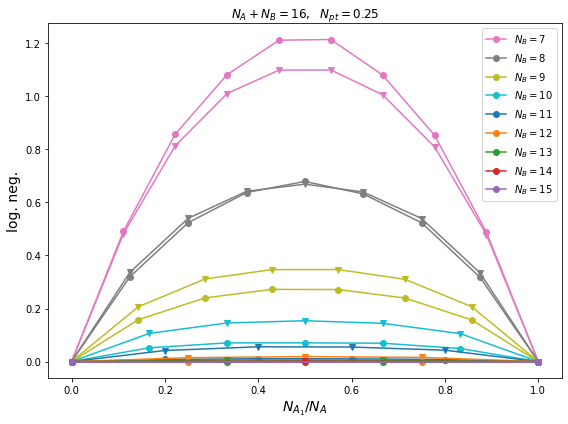

In [17]:
out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1


Labc_list = [16]
Npt = 4

plt.figure(figsize=(8,6))

for Labc in Labc_list:
#     Npt = int(Labc/2)
    for Lc in range(7,Labc):
        Lab = Labc-Lc
        ln_avg= np.zeros(Lab+1)
        mi_avg= np.zeros(Lab+1)
        for La in range(1,Lab):
            Lb = Labc-Lc-La
            if symm==1:
                f1= 'LN_U1_%d_Labc_%d_%d_%d_symm.npz' % (Npt,La,Lb,Lc)
            else:
                f1= 'LN_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
            fname = out_dir+f1

            npzfile = np.load(fname)
            ln_vals=npzfile['ln_vals']
            ln_avg[La] = np.mean(ln_vals)
            mi_vals=npzfile['mi_vals']
            mi_avg[La] = np.mean(mi_vals)
        plt.plot(np.arange(Lab+1)/Lab,ln_avg,"o-",color="C%d" % (Lc-1),label=r"$N_B=%d$" % (Lc))
        plt.plot(np.arange(Lab+1)/Lab,0.5*mi_avg,"v-",color="C%d" % (Lc-1))
        if Lab>Lc-2:
            N_La = 40
            La_list = np.linspace(0.01,0.99,N_La)*Lab
            ln_ref= np.zeros(N_La)
            for i_a in range(N_La):
                La = La_list[i_a]
                Lb = Labc-Lc-La
                if La<Lb:
                    Na = 2**La
                    Nb = 2**Lb
                    Nc = 2**Lc
                else:
                    Na = 2**Lb
                    Nb = 2**La
                    Nc = 2**Lc
                a = Nc/Nb +1j*0
                b = Nc/Nb*Na +1j*0
                ln_ref[i_a]=np.log2(neg_calc(a,b)*(Nb*Na)/pi/(Na*Nc))

    # #             f1= 'LN_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
    #             f1= 'LN_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    #             fname = out_dir+f1

    #             npzfile = np.load(fname)
    #             ln_vals=npzfile['ln_vals']
    #             ln_avg_ref[La] = np.mean(ln_vals)
#             plt.plot(La_list/Lab,ln_ref,"--",color="C%d" % (Lc-1))


# lw=0.2
# ymax=0.3
# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.ylim(-0.01,ymax)
# # plt.xlim(-0.1,1)
# # plt.yticks(np.arange(0.,ymax+0.1,0.5))
plt.legend()
fsize=14
plt.xlabel(r'$N_{A_1}/N_A$',fontsize = fsize)
plt.ylabel("log. neg.",fontsize = fsize)
plt.title(r'$N_A+N_B = %d,\ \ N_{pt}=%.2f$' % (Labc,Npt/Labc))

plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

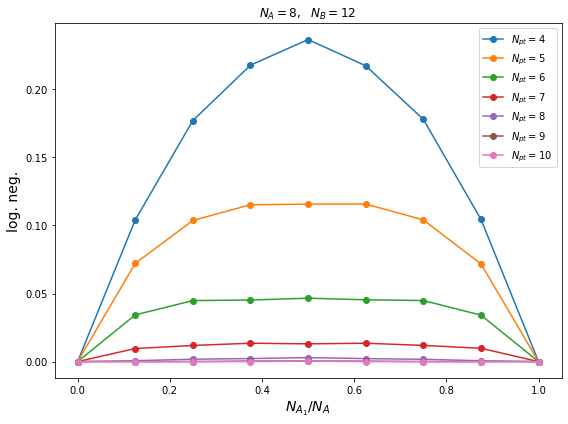

In [365]:
# sweeping filling fraction

out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1

Labc_list = [20]
Lc = 12

plt.figure(figsize=(8,6))

for Labc in Labc_list:
    Lab = Labc-Lc
    ln_avg= np.zeros(Lab+1)
    for Npt in range(4,int(Labc/2)+1):
        for La in range(1,Lab):
            Lb = Labc-Lc-La
            if symm==1:
                f1= 'LN_U1_%d_Labc_%d_%d_%d_symm.npz' % (Npt,La,Lb,Lc)
            else:
                f1= 'LN_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
            fname = out_dir+f1

            npzfile = np.load(fname)
            ln_vals=npzfile['ln_vals']
            ln_avg[La] = np.mean(ln_vals)
        plt.plot(np.arange(Lab+1)/Lab,ln_avg,"o-",color="C%d" % (Npt-4),label=r"$N_{pt}=%d$" % (Npt))
    if Lab>Lc-2:
        N_La = 40
        La_list = np.linspace(0.01,0.99,N_La)*Lab
        ln_ref= np.zeros(N_La)
        for i_a in range(N_La):
            La = La_list[i_a]
            Lb = Labc-Lc-La
            if La<Lb:
                Na = 2**La
                Nb = 2**Lb
                Nc = 2**Lc
            else:
                Na = 2**Lb
                Nb = 2**La
                Nc = 2**Lc
            a = Nc/Nb +1j*0
            b = Nc/Nb*Na +1j*0
            ln_ref[i_a]=np.log2(neg_calc(a,b)*(Nb*Na)/pi/(Na*Nc))

# #             f1= 'LN_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
#             f1= 'LN_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
#             fname = out_dir+f1

#             npzfile = np.load(fname)
#             ln_vals=npzfile['ln_vals']
#             ln_avg_ref[La] = np.mean(ln_vals)
        plt.plot(La_list/Lab,ln_ref,"k--")


# lw=0.2
# ymax=0.3
# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.ylim(-0.01,ymax)
# # plt.xlim(-0.1,1)
# # plt.yticks(np.arange(0.,ymax+0.1,0.5))
plt.legend()
fsize=14
plt.xlabel(r'$N_{A_1}/N_A$',fontsize = fsize)
plt.ylabel("log. neg.",fontsize = fsize)
plt.title(r'$N_A = %d,\ \ N_{B}=%d$' % (Lab,Lc))

plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

# charge projection

In [24]:
Nrep=2000
r=2 # local Hilbert space dim
symm=1

La=2
Lb=6
Na=r**La
Nb=r**Lb

Lc=6

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
Npt_ab_list=np.arange(2,5)

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

# print(len(i_ab))
# print(s_ab[np.ix_(i_ab),:])

# for i_r in range(La+Lb+1):
#     print(i_ab[i_r])
#     print(s_ab[np.ix_(i_ab[i_r]),:])

# for i_r in range(Lc+1):
#     print(i_c[i_r])
#     print(s_c[np.ix_(i_c[i_r]),:])

v1T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()

for i_pt in Npt_ab_list:
    print(Npt,i_pt)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    for i_r in range(Nrep):
        i_r
        if symm==1:
            if (Npt-i_pt) <= Lc:
                X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT2 = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT2)
        v1T[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T

    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)

    fname = out_dir+f1
    np.savez(fname, evals=v1T, Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


7 2
7 3
7 4
Finished, elapsed time = 56.14 sec


ES was loaded!
ES was loaded!
ES was loaded!


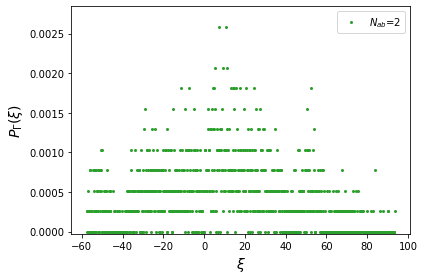

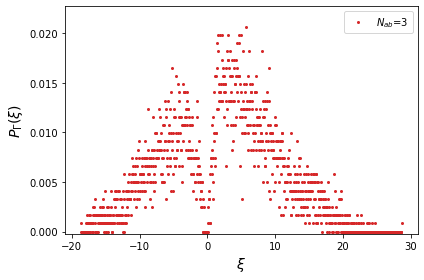

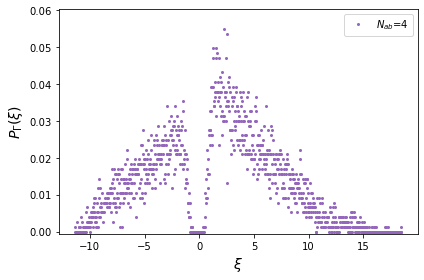

In [27]:
out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1


La=2
Lb=6
Na=r**La
Nb=r**Lb

Lc=4

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
Npt_ab_list=np.arange(2,5)

def semicirc_dist(N,Q,x,x0):
    # my Q is from Ludwig's paper
    R= 2*sqrt(Q)
    fx= 2/(pi*R**2)*(R**2-(x-x0)**2+0j)**0.5
    return fx



for i_pt in Npt_ab_list:
    plt.figure(figsize=(6,4))
    
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    v1T=npzfile['evals']
    print('ES was loaded!')
    
    num_bins = 1000


    n, bin_edges = np.histogram(v1T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2

    if symm==1:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])    
    else:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])  
        
    plt.plot(bins_center,n,'o',markersize=2,color='C%d' % (i_pt), label='$N_{ab}$=%d' % (i_pt))
    
#     xplot=np.linspace(-1.9,2.9,1000)
#     xplot=np.linspace(-1.1,3.1,1000)
#     if symm==1:
#         fx1= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,0)*(r-1)/r
#         fx2= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,1)/r
#         plt.plot(xplot,np.real(fx1+fx2),color='C%d' % (i_l))
#     else:
#         fx= semicirc_dist(Nab_r,Na*Nb/r**Lc,xplot,1)
#         plt.plot(xplot,np.real(fx),color='C%d' % (i_l))

    lw=0.2
    ymax=np.sort(n)[-2]*1.1
    plt.legend()
    plt.ylim(-ymax/100,ymax)

# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# plt.xscale("log")
# plt.yscale("log")
    # plt.xlim(-10,10)
    # plt.yticks(np.arange(0.,ymax+0.1,0.5))
    # plt.legend()
    fsize=14
    if symm==1:
        plt.ylabel(r'$P_\Gamma(\xi)$',fontsize = fsize)
        plt.xlabel(r"$\xi$",fontsize = fsize)
    else:
        plt.ylabel(r'$P_\Gamma(\xi)$',fontsize = fsize)
        plt.xlabel(r"$ \xi$",fontsize = fsize)

    plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

# charge projection, decomposed partial transpose

In [ ]:
Nrep = 10000
r=2 # local Hilbert space dim
symm=1

La=5
Lb=5
Na=r**La
Nb=r**Lb

Lc=12

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
# Npt_ab_list=np.arange(2,Npt)
Npt_ab_list=np.arange(3,7)

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

vT=np.zeros(Nrep*Nb*Na)
v2T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()

for i_pt in Npt_ab_list:
    print(Npt,i_pt)
    
    Nab_r = len(i_ab[i_pt]) # size of sub-Hilbert space
    v1T=np.zeros(Nrep*Nab_r)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    for i_r in range(Nrep):
        i_r
        if symm==1:
            if (Npt-i_pt) <= Lc:
                X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT)
        vT[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T

        rT1 = rT[np.ix_(i_ab[i_pt],i_ab[i_pt])]
        l1T=np.linalg.eigvalsh(rT1)
        v1T[i_r*Nab_r:(i_r+1)*Nab_r] = Nab_r *l1T
        rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] = 0* rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] 
        l1T=np.linalg.eigvalsh(rT)
        v2T[i_r*Nb*Na:(i_r+1)*Na*Nb] = Nab_r *l1T

        
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)

    fname = out_dir+f1
    np.savez(fname, evals=vT, evals1=v1T, evals2=v2T, Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


11 3


ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!
ES was loaded!


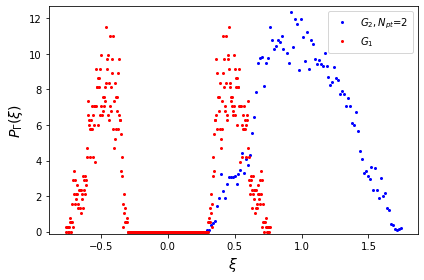

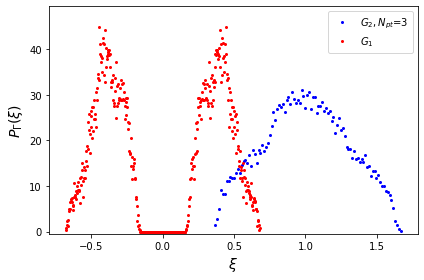

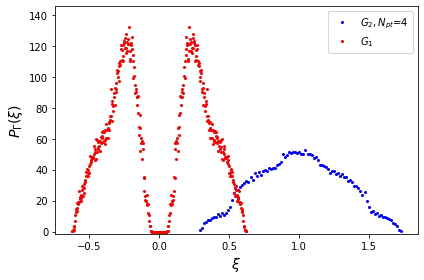

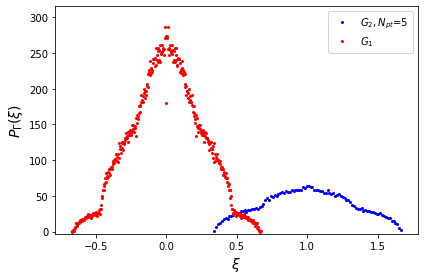

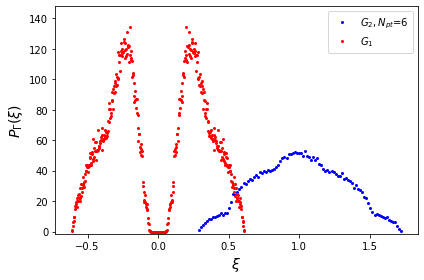

In [74]:
out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1


La=5
Lb=5
Na=r**La
Nb=r**Lb

Lc=12

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
Npt_ab_list=np.arange(2,7)

def semicirc_dist(N,Q,x,x0):
    # my Q is from Ludwig's paper
    R= 2*sqrt(Q)
    fx= 2/(pi*R**2)*(R**2-(x-x0)**2+0j)**0.5
    return fx

for i_pt in Npt_ab_list:
    plt.figure(figsize=(6,4))
    
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT=npzfile['evals']
    v1T=npzfile['evals1']
    v2T=npzfile['evals2']
    print('ES was loaded!')
    
    if r**Lc > 4* r**(La+Lb)+1:
        num_bins = 100
        print(L)
    else:
        num_bins = 100


#     n, bin_edges = np.histogram(vT, bins=num_bins)
#     bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     N0=np.sum(n)/Nrep
#     print("total is ", N0)
#     n= n/Nrep/(bin_edges[1]-bin_edges[0])            
#     plt.plot(bins_center,n,'v',markersize=4,color='C%d' % (i_pt-1), label='$N_{ab}$=%d' % (i_pt))

        
    Nab_r = len(i_ab[i_pt]) # size of sub-Hilbert space
    n, bin_edges = np.histogram(v1T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     print(np.sum(n)/Nrep-Nab_r-N0)
    n= n/Nrep/(bin_edges[1]-bin_edges[0])            
    plt.plot(bins_center,n,'o',markersize=2,color='b' , label=r'$G_2, N_{pt}$=%d' % (i_pt))

    num_bins = 400
    n, bin_edges = np.histogram(v2T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/Nrep/(bin_edges[1]-bin_edges[0])            
    plt.plot(bins_center,n,'o',markersize=2,color='r', label=r'$G_1$')

    ymax=np.sort(n)[-3]*1.1
    plt.legend()
    plt.ylim(-ymax/100,ymax)

    
#     xplot=np.linspace(-1.9,2.9,1000)
#     xplot=np.linspace(-1.1,3.1,1000)
#     if symm==1:
#         fx1= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,0)*(r-1)/r
#         fx2= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,1)/r
#         plt.plot(xplot,np.real(fx1+fx2),color='C%d' % (i_l))
#     else:
#         fx= semicirc_dist(Nab_r,Na*Nb/r**Lc,xplot,1)
#         plt.plot(xplot,np.real(fx),color='C%d' % (i_l))

    lw=0.2

# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# plt.xscale("log")
# plt.yscale("log")
    # plt.xlim(-10,10)
    # plt.yticks(np.arange(0.,ymax+0.1,0.5))
    # plt.legend()
    fsize=14
    if symm==1:
        plt.ylabel(r'$P_\Gamma(\xi)$',fontsize = fsize)
        plt.xlabel(r"$\xi$",fontsize = fsize)
    else:
        plt.ylabel(r'$P_\Gamma(\xi)$',fontsize = fsize)
        plt.xlabel(r"$ \xi$",fontsize = fsize)

    plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

In [68]:
Nrep=1000
r=2 # local Hilbert space dim
symm=1

La=6
Lb=2
Na=r**La
Nb=r**Lb

Lc=5

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
# Npt_ab_list=np.arange(2,Npt)
Npt_ab_list=np.array([2])

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

vT=np.zeros(Nrep*Nb*Na)
v2T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()

for i_pt in Npt_ab_list:
    print(Npt,i_pt)
    
    Nab_r = len(i_ab[i_pt]) # size of sub-Hilbert space
    v1T=np.zeros(Nrep*Nab_r)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    
    dz= 5e-3
    zsw = np.linspace(-5,5,100) + 1j*dz
    G= np.zeros((Na*Nb,Na*Nb,len(zsw))) 
    for i_r in range(Nrep):
        i_r
        if symm==1:
            if (Npt-i_pt) <= Lc:
                X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT)
        vT[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T
        for i_z in range(len(zsw)):
            G[:,:,i_z] += np.imag(np.linalg.inv(zsw[i_z]*eye(Na*Nb)-Nab_r*rT))
            
#         rT1 = rT[np.ix_(i_ab[i_pt],i_ab[i_pt])]
#         l1T=np.linalg.eigvalsh(rT1)
#         v1T[i_r*Nab_r:(i_r+1)*Nab_r] = Nab_r *l1T
#         rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] = 0* rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] 
#         l1T=np.linalg.eigvalsh(rT)
#         v2T[i_r*Nb*Na:(i_r+1)*Na*Nb] = Nab_r *l1T

        
#     out_dir = 'data/' 
#     if symm==1:
#         f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
#     else:
#         f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)

#     fname = out_dir+f1
#     np.savez(fname, evals=vT, evals1=v1T, evals2=v2T, Nrep=Nrep)
    G /= Nrep

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


6 2
Finished, elapsed time = 390.76 sec


(-0.1, 12.0)

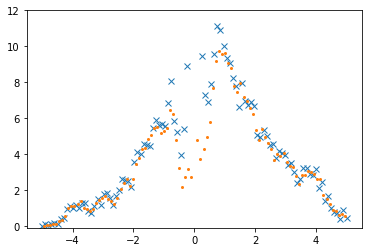

In [69]:
trG = np.zeros(len(zsw))
for i_z in range(len(zsw)):
    trG[i_z] = np.trace(G[:,:,i_z])
plt.plot(np.real(zsw),-trG/pi,'x')


num_bins = len(zsw) -1 
n, bin_edges = np.histogram(vT, bins=np.real(zsw))
bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
n= n/Nrep/(bin_edges[1]-bin_edges[0])            
plt.plot(bins_center,n,'.',markersize=4)#, label='$N_{ab}$=%d' % (i_pt))
plt.ylim([-0.1,12])
    

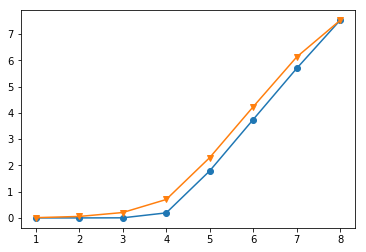

In [19]:
neg_full_avg=np.mean(neg_full,axis=1)
neg_symm_avg=np.mean(neg_symm,axis=1)
plt.figure()
plt.plot(La_sw,neg_full_avg,'o-')
plt.plot(La_sw,neg_symm_avg,'v-')
plt.show()

In [ ]:
neg_avg1=np.mean(neg_q,axis=1)
print(neg_avg1)
plt.figure()
plt.plot(La_sw,neg_avg1,'o-')
# plt.plot(La_sw,negb,'v')
plt.show()

In [ ]:
Nrep=10
r=2 # local Hilbert space dim

L=12
La_sw=[6] #range(1,4)
# La_sw=range(1,int(L/2)+1)

negb=np.zeros((len(La_sw),Nrep))
# np.random.seed(1)

t_timer=time.time()

for i_l in range(len(La_sw)):
    La=La_sw[i_l]
    Lb=La
    Lc=L-La-Lb
    print(' ',La)
    
    Na=r**La
    Nb=r**Lb
    Nc=r**Lc
    
    s_c=Hilbertspace_Zr(Lc,r)
    s_ab=Hilbertspace_Zr(La+Lb,r)

    i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
    if Lc>0:
        i_c=np.zeros((r**(Lc-1),r),dtype=int)
    else:
        i_c=np.zeros((1,r),dtype=int)
    ### indices of r multiples
#     for i_Zr in range(r):
    i_Zr=0
    i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]
    i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]


    Ne_ab=r**(La+Lb-1)
    Ne_c=r**(Lc-1)
    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

    for i_r in range(Nrep):

        if Lc>0:
            X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Ne_ab,Ne_c)+ 1j*np.random.randn(Ne_ab,Ne_c)
        else:
            X[i_ab[:,0],0]=np.random.randn(Ne_ab)+ 1j*np.random.randn(Ne_ab)


        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        lT=np.linalg.eigvalsh(rT)
        negb[i_l,i_r]=np.log2(np.sum(np.abs(lT)))

            
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


In [ ]:
# print(X)
print(negb)

In [ ]:
negb_avg=np.mean(negb,axis=1)
plt.figure()
plt.plot(La_sw,neg_avg,'o-')
plt.plot(La_sw,negb_avg,'v')
plt.show()

In [14]:
# bipartite entanglement

Nrep=1000
r=5 # local Hilbert space dim

La=3
Lb=0
L=2*La
Lc=L-La-Lb

Na=r**La
Nb=r**Lb
Nc=r**Lc

s_c=Hilbertspace_Zr(Lc,r)
s_ab=Hilbertspace_Zr(La+Lb,r)

i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
i_c=np.zeros((r**(Lc-1),r),dtype=int)
### indices of r multiples
for i_r in range(r):
    i_c[:,i_r]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_r)[:,0]
    i_ab[:,i_r]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_r)[:,0]

Nab_r=int(Nb*Na/r)
Nc_r=r**(Lc-1)
X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

ent0=np.zeros(Nrep)
ent1=np.zeros(Nrep)

for i_r in range(Nrep):
    #### no symmetry
    X0=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc)
    mat=np.dot(X0,np.matrix(X0).H)
    rho= mat / np.trace(mat)    
    ent0[i_r]=vNent_calc(rho)

    X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    for i_Zr in np.arange(1,r):
        X[np.ix_(i_ab[:,i_Zr],i_c[:,r-i_Zr])]=np.random.randn(Nab_r,Nc_r)+1j*np.random.randn(Nab_r,Nc_r)

#     X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
#     X[np.ix_(i_ab[:,1],i_c[:,1])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    mat=np.dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)    
    ent1[i_r]=vNent_calc(rho)
    
print(np.mean(ent0))
print(np.mean(ent1))
print(np.log(Na)-0.5)

4.328390084765682
4.328744035803526
4.3283137373023015


In [ ]:
# rho.shape
# X.shape
# i_ab[:,0]
# np.linalg.eigvalsh(rho)